In [2]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Convolution2D,MaxPooling2D,Flatten,Conv2D,Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import keras_tuner as kt
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import cv2

In [3]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
NUM_CLASSES = 17

IMAGE_SIZE = 120

DATASET_PATH = "../data/pokemon_per_type"

In [5]:
# Creating the model

DROPOUT = 0.3

model=Sequential()

model.add(Dense(4, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(DROPOUT))


model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(DROPOUT))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(DROPOUT))

model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (3, 3)))
model.add(Dropout(DROPOUT))

model.add(Flatten())
model.add(Dense(2048, activation = 'relu'))
model.add(Dropout(DROPOUT))


model.add(Dense(NUM_CLASSES, activation = 'softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120, 120, 4)       16        
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 32)      1184      
                                                                 
 batch_normalization (BatchN  (None, 118, 118, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 59, 59, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        1

In [7]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [8]:
def to_lab(image):
    image = np.array(image)
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    return lab_image

train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   rotation_range = 20,
                                   horizontal_flip = True,
                                  #  preprocessing_function = to_lab
                                )

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  # preprocessing_function = to_lab
                                )

val_datagen = ImageDataGenerator(rescale = 1./255,
                                  # preprocessing_function = to_lab
                                )                     

batch_size = 32

training_set = train_datagen.flow_from_directory(DATASET_PATH + '/train', 
                                                    target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                                    batch_size = batch_size)
val_set = test_datagen.flow_from_directory(DATASET_PATH + '/val',
                                           target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                           batch_size = batch_size)

test_set = test_datagen.flow_from_directory(DATASET_PATH + '/test',
                                            target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = batch_size)

Found 638 images belonging to 17 classes.
Found 80 images belonging to 17 classes.
Found 88 images belonging to 17 classes.


In [22]:
nb_epochs = 50
fitted_model = model.fit(training_set,
                        epochs = nb_epochs,
                        validation_data = val_set)

Epoch 1/50
40/40 [==============================] - 2s 46ms/step - loss: 0.9045 - accuracy: 0.6991 - val_loss: 9.1779 - val_accuracy: 0.2125
Epoch 2/50
40/40 [==============================] - 2s 42ms/step - loss: 1.0302 - accuracy: 0.6646 - val_loss: 6.2981 - val_accuracy: 0.1625
Epoch 3/50
40/40 [==============================] - 2s 44ms/step - loss: 0.9679 - accuracy: 0.6755 - val_loss: 4.5110 - val_accuracy: 0.1375
Epoch 4/50
40/40 [==============================] - 2s 43ms/step - loss: 1.0425 - accuracy: 0.6567 - val_loss: 11.5009 - val_accuracy: 0.1625
Epoch 5/50
40/40 [==============================] - 2s 42ms/step - loss: 0.9764 - accuracy: 0.6740 - val_loss: 5.2297 - val_accuracy: 0.2375
Epoch 6/50
40/40 [==============================] - 2s 42ms/step - loss: 0.9859 - accuracy: 0.6991 - val_loss: 9.1015 - val_accuracy: 0.1625
Epoch 7/50
40/40 [==============================] - 2s 41ms/step - loss: 0.9444 - accuracy: 0.6991 - val_loss: 7.9864 - val_accuracy: 0.1875
Epoch 8/50
4

In [23]:
results = model.evaluate(test_set)


6/6 [==============================] - 0s 9ms/step - loss: 10.2754 - accuracy: 0.1818


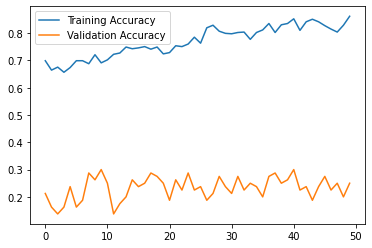

In [24]:
plt.figure()
plt.plot([i for i in range(nb_epochs)],fitted_model.history['accuracy'], label = "Training Accuracy")
plt.plot([i for i in range(nb_epochs)],fitted_model.history['val_accuracy'], label = "Validation Accuracy")
plt.legend()

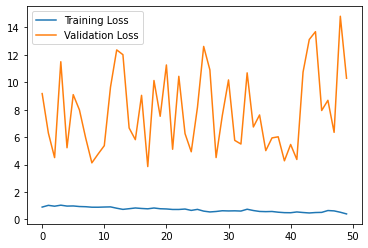

In [25]:
plt.figure()
plt.plot([i for i in range(nb_epochs)],fitted_model.history['loss'], label = "Training Loss")
plt.plot([i for i in range(nb_epochs)],fitted_model.history['val_loss'], label = "Validation Loss")
plt.legend()

In [9]:
#Now tryning to fine tune parameters with keras tuning :

def build_model(hp):
    model = Sequential()
    model.add(Dense(4, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(hp.Float('dropout', 0.0, 0.5, 0.1))) #Fine tune dropout parameter from 0.0 to 0.5 with a step size of 0.1


    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(hp.Float('dropout', 0.0, 0.5, 0.1))) 


    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(hp.Float('dropout', 0.0, 0.5, 0.1)))


    model.add(Conv2D(256, (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3, 3)))
    model.add(Dropout(hp.Float('dropout', 0.0, 0.5, 0.1)))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense', 32, 2048, 32), activation = 'relu')) #Fine tune units from 32 to 2048 units with step size 32
    model.add(Dropout(hp.Float('dropout', 0.0, 0.5, 0.1)))


    model.add(Dense(NUM_CLASSES, activation = 'softmax'))

    hp_learning_rate = hp.Choice('learning_rate', [0.001, 0.01, 0.1, 1.0])

    model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(hp_learning_rate), metrics = ['accuracy'])

    return model


In [10]:
tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy',
                     max_epochs = 50,
                     seed = 42,
                     project_name = 'pokemon_cnn_tuning',
                     factor = 3,
                     hyperband_iterations = 10,
                     directory = '../checkpoints/')

INFO:tensorflow:Reloading Oracle from existing project ../checkpoints/pokemon_cnn_tuning\oracle.json
INFO:tensorflow:Reloading Tuner from ../checkpoints/pokemon_cnn_tuning\tuner0.json


In [11]:
#Search space for hyperparameters tuning
tuner.search_space_summary()

Search space summary
Default search space size: 3
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 2048, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1, 1.0], 'ordered': True}


In [12]:
stop_early = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10) #stop early if no improvement in 10 epochs

In [20]:
nb_epochs = 100
tuner.search(training_set,
             validation_data = val_set,
             epochs = nb_epochs,
             verbose = 1,
             callbacks = [stop_early] #Add early stopping callback to fasten the process
             )

INFO:tensorflow:Oracle triggered exit


In [52]:
#Get optimal parameters
best_hps = tuner.get_best_hyperparameters()[0]
print("Learning rate = ", best_hps.get('learning_rate'))
print("Dropout = ", best_hps.get('dropout'))
print("Dense units = ", best_hps.get('dense'))

#Building h_model
h_model = build_model(best_hps)

#Train the model with best hyperparameters
nb_epochs = 500
fitted_h_model = h_model.fit(training_set,
                             epochs = nb_epochs,
                             validation_data = val_set)


Learning rate =  0.001
Dropout =  0.2
Dense units =  832
Epoch 1/500
20/20 [==============================] - 2s 86ms/step - loss: 8.7130 - accuracy: 0.1113 - val_loss: 6.2089 - val_accuracy: 0.0500
Epoch 2/500
20/20 [==============================] - 2s 85ms/step - loss: 3.1819 - accuracy: 0.1693 - val_loss: 3.7493 - val_accuracy: 0.1000
Epoch 3/500
20/20 [==============================] - 2s 84ms/step - loss: 2.6802 - accuracy: 0.2100 - val_loss: 4.5068 - val_accuracy: 0.1000
Epoch 4/500
20/20 [==============================] - 2s 95ms/step - loss: 2.5981 - accuracy: 0.2085 - val_loss: 4.8677 - val_accuracy: 0.1875
Epoch 5/500
20/20 [==============================] - 2s 91ms/step - loss: 2.4364 - accuracy: 0.2429 - val_loss: 5.0850 - val_accuracy: 0.0625
Epoch 6/500
20/20 [==============================] - 2s 93ms/step - loss: 2.4184 - accuracy: 0.2414 - val_loss: 6.3983 - val_accuracy: 0.0875
Epoch 7/500
20/20 [==============================] - 2s 90ms/step - loss: 2.3459 - accuracy

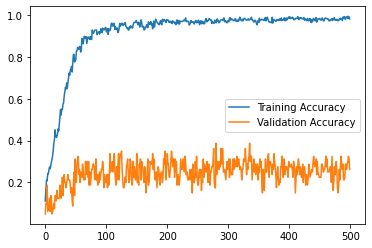

In [59]:
plt.figure()
plt.plot([i for i in range(nb_epochs)],fitted_h_model.history['accuracy'], label = "Training Accuracy")
plt.plot([i for i in range(nb_epochs)],fitted_h_model.history['val_accuracy'], label = "Validation Accuracy")
plt.legend()

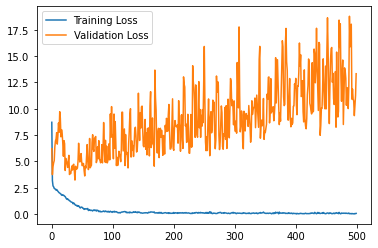

In [60]:
plt.figure()
plt.plot([i for i in range(nb_epochs)],fitted_h_model.history['loss'], label = "Training Loss")
plt.plot([i for i in range(nb_epochs)],fitted_h_model.history['val_loss'], label = "Validation Loss")
plt.legend()

In [61]:
#Evaluating the model on test set
test_accuracy = h_model.evaluate(test_set)[1]

print("Test accuracy = ", test_accuracy)

3/3 [==============================] - 0s 53ms/step - loss: 16.9132 - accuracy: 0.2500
Test accuracy =  0.25


In [64]:
def pred(image_path, model):
    image = Image.open(image_path)
    image = image.resize((IMAGE_SIZE,IMAGE_SIZE))
    x = np.array(image)
    x = np.expand_dims(x,axis=0)
    c = np.argmax(model.predict(x), axis=1)
    l = os.listdir(DATASET_PATH + '/train')
    l.sort()
    return l[c[0]]


pred(DATASET_PATH + '/test/Electric/electabuzz.png', h_model)

'Dragon'